# dataloader notebook 
loading data from disk to actually get a dataframe ready for training

In [1]:
# Import statements
import yfinance as yf
import pandas as pd
import os
import numpy as np
from datetime import date
from pathlib import Path
import pandas_ta as ta
from tqdm import tqdm
from price_data_pull_yfinance import gethistoricalOHLC, saveHistStockData, loadHistDataFromDisk

from global_vars import dataPathToOHLC, pathToMasterDF, float16Cols, float32Cols, dataPathToTechIndicators

In [2]:
pd.set_option('display.max_columns', 500)

## Import all important stuff

In [5]:
masterDf = pd.read_csv(pathToMasterDF);
tickerDF = pd.read_csv('../01_data/SnP500_constituents.csv')
mdf = masterDf

## data sanity checks
Lets check all the data that we have on disk and compare it with the data that should be the tickers.

In [28]:
symbol_list = tickerDF.Symbol.to_list();
ticker_list = mdf[mdf.FILEPATH_TECH_IND_CALC != ''].TICKER.to_list()

In [41]:
def getTickersOnDisk(path):
    arr = os.listdir(path)
    tickers_on_disk = [ticker.split('_')[0] for ticker in arr]
    return tickers_on_disk

In [43]:
tickers_on_disk = getTickersOnDisk('../01_data/01_price_data/01_price_data_w_tech_indicators/');
tickers_on_disk[:5]

['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC']

In [46]:
problematic_tickers = [ticker for ticker in ticker_list if ticker not in tickers_on_disk]

In [78]:
APPL_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/AAPL_tech_ind_calculated')
KO_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/KO_tech_ind_calculated')
DVN_df = pd.read_feather('../01_data/01_price_data/01_price_data_w_tech_indicators/DVN_tech_ind_calculated')

### Instable Candle TA - One time clean up
Unfortunately we saw that the candle stick based indicators are somewhat instable so, we are going to remove them from our datasets.  
As the calculation is rather memory intensive, we are going to just drop them from the other data


In [75]:
missing_cols = [col for col in APPL_df.columns if col not in KO_df.columns]
missing_cols

['index',
 'CDL_DOJI_10_0.1',
 'CDL_INSIDE',
 'HA_open',
 'HA_high',
 'HA_low',
 'HA_close']

#### clean up loop

In [77]:
for ticker in tqdm(tickers_on_disk):
    ticker_full_name = ticker + '_tech_ind_calculated'
    filepath = Path('../01_data/01_price_data/01_price_data_w_tech_indicators/').joinpath(ticker_full_name) 
    df = pd.read_feather(filepath)

    bad_cols_to_drop = [col for col in df.columns if col in missing_cols]
    if len(bad_cols_to_drop) > 0:
        df = df.drop(bad_cols_to_drop, axis=1)
        df.to_feather(filepath)

100%|██████████| 503/503 [00:29<00:00, 16.85it/s]


### Lets look at the data in the S&P 500

In [80]:
import seaborn as sns

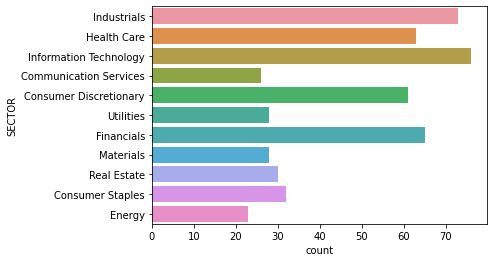

In [82]:
ax = sns.countplot(y="SECTOR", data=mdf)

In [95]:
mdf['FIRST_DATE_OHLC'] = pd.to_datetime(mdf['FIRST_DATE_OHLC']) 
type(mdf.FIRST_DATE_OHLC.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:xlabel='FIRST_DATE_OHLC'>

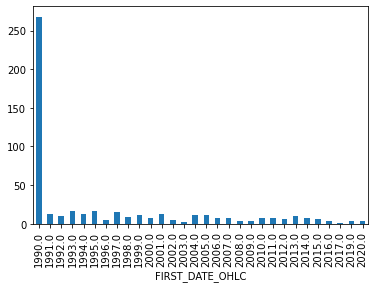

In [97]:
mdf.groupby(mdf["FIRST_DATE_OHLC"].dt.year).SECTOR.count().plot(kind="bar")